In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import random
import time as tm
from scipy.optimize import curve_fit
import xml.dom.minidom as minidom

Welcome to JupyROOT 6.24/02


In [2]:
filename = "/Users/williamquinn/Desktop/A1400_B1400_t1119.xml"
file = minidom.parse(filename)

In [3]:
traces = file.getElementsByTagName('trace')
print(traces.length)

400000


In [4]:
trace = traces[0]
channel = int(trace.attributes['channel'].value)
print(channel)

0


In [5]:
def get_pulse_par(x, y, baseline):
    x = np.array(x)
    
    pulse_length = len(x)
    amplitude = np.min(y) - baseline;
    position = np.argmin(y)

    start=0
    stop=0
    for i in range(position):
    
        if (y[i]-baseline) < (0.3*amplitude):
            start = i
        if (y[i]-baseline) < (0.7*amplitude):
            stop = i
    
    rise = stop - start
    onset = start

    for i in range(position, pulse_length):
        if (y[i]-baseline) > (amplitude/np.exp(1.0)):
            stop = i;
    fall = stop - position
  
    return onset, rise, fall

def get_baseline(y):
    baseline = 0
    for i in range(100):
        baseline += y[i]
    return baseline/100

def get_amplitude(y, baseline):
    return np.min(y) - baseline

def pulse(x, onset, rise, fall, pos):
    y = []
    for i in range(len(x)):
        if i < onset:
            y.append(0)
        else:
            temp = -np.exp(-(x[i]-pos)/rise) + np.exp(-(x[i]-pos)/fall)
            y.append(temp)
    return y

Text(0.5, 0, 'timestamp /ns')

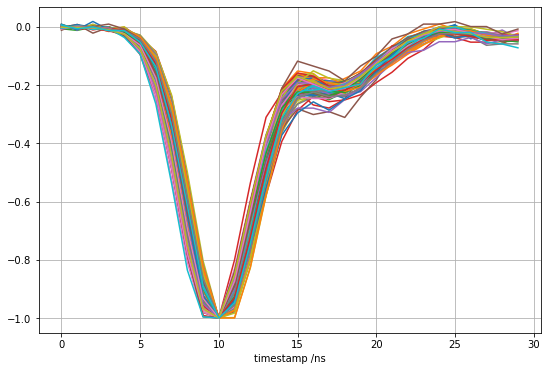

In [74]:
average_waveform = []
average_counter = 0
fig = plt.figure(figsize=(9,6), facecolor='white')
for i in range(int(traces.length)):
    trace = traces[i].firstChild.data.split(" ")[:-1]
    channel = int(traces[i].attributes['channel'].value)
    if channel == 1:
        continue
    waveform = np.array(trace, dtype='float')
    
    baseline = get_baseline(waveform)
    amplitude = get_amplitude(waveform, baseline)
    
    if amplitude > -100:
        continue
    
    if 0 in waveform:
        continue
    else:
        if len(average_waveform) == 0:
            average_waveform = np.zeros_like(waveform[:30])
        else:
            pos = np.argmin(waveform - baseline)
            size = np.min(waveform - baseline)
            if pos > 700:
                continue
            plt.plot(-1*(waveform - baseline)[pos-10:pos+20]/size)
            
            average_counter += 1
            average_waveform += -1*(waveform - baseline)[pos-10:pos+20]/size
            
            if average_counter == 100:
                break
            
    if i % 1000 == 0:
        print(i)
        
plt.grid()
plt.xlabel('timestamp /ns')

In [8]:
def gaus(x, A, mu, sig):
    return A*np.exp( -0.5*((x-mu)/sig)**2 )

[-1.00798842 10.11116109  2.21924508]


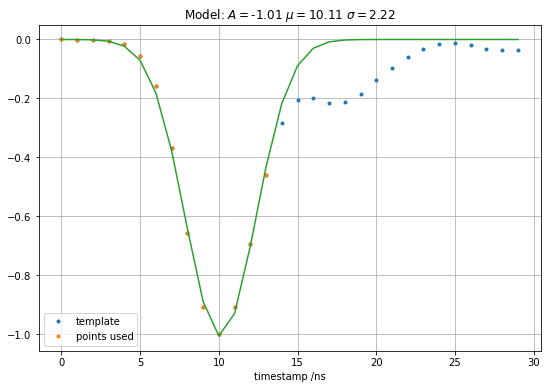

In [85]:
template = average_waveform/average_counter
fig = plt.figure(figsize=(9,6), facecolor='white')
plt.plot(template, ".", label='template')
x = np.array([i for i in range(len(template))])
popt, pcov = curve_fit(f=gaus, xdata=x[:-16], ydata=template[:-16], bounds = [[-1000, 0, 0], [0, 1000, 1000]])
plt.plot(x[:-16], template[:-16], ".", label ='points used' )
A = popt[0]
mu = popt[1]
sig = popt[2]
plt.plot(x,gaus(x,*popt))
print(popt)
plt.xlabel('timestamp /ns')
plt.grid()
plt.title(r'Model: $A=${:.2f} $\mu=${:.2f} $\sigma=${:.2f}'.format(popt[0], popt[1], sig))
plt.legend()
#plt.yscale('log')
plt.savefig('/Users/williamquinn/Desktop/pulse_fit.pdf')

In [14]:
def gaus_fix_sig(x, A, mu):
    return A*np.exp( -0.5*((x-mu)/2.21924508)**2 )

In [62]:
counter = 0
fit_counter = 0
charges = []
for i in range(int(traces.length)):
    trace = traces[i].firstChild.data.split(" ")[:-1]
    channel = int(traces[i].attributes['channel'].value)
    if channel == 1:
        continue
    waveform = np.array(trace, dtype='float')
    
    baseline = get_baseline(waveform)
    amplitude = get_amplitude(waveform, baseline)
    
    if i % 10000 == 0:
        print(i)
    
    if amplitude > -50:
        continue
        
    if 0 in waveform:
        pass
    else:
        charge = np.sum((waveform - baseline)[pos-10:pos+20])/50
        charges.append(charge)
        continue
    
    # pos = np.argmin(waveform - baseline)
    pos = np.where( waveform==0 )[0]
    
    middle = int(len(pos) / 2) # = int(2.5) = 2
    pos=pos[middle] # 3
    size = np.min(waveform - baseline)
    
    waveform_r = (waveform - baseline)[pos-10:pos+20]
    pulse = waveform[pos-10:pos+20]
    
    #fig = plt.figure(figsize=(9,6), facecolor='white')
    #plt.plot([k for k in range(len(waveform_r))], waveform_r, '.', label='pmt pulse')
    # plt.plot([k for k in range(len(waveform_r))], template*-1*size *1.7, '.')
    #plt.grid()
    #plt.xlabel('timestamp /ns')
    #plt.ylabel('Voltage /mV')
    
    fit_counter += 1
    shapes = []
    # sizes = np.linspace(0,5,5000)
    sizes = [1]
    
    new_pulse = []
    xi = []
    for j in range(len(pulse)):
        if j > 14:
            break
        if pulse[j] == 0:
            continue
        else:
            new_pulse.append(waveform_r[j])
            xi.append(j)
            
    popt, pcov = curve_fit(f=gaus_fix_sig, xdata=np.array(xi), ydata=new_pulse, bounds=[[-10000, 0], [0, 40]])
    
    #plt.plot([k for k in range(len(waveform_r))], -1*template*popt[0], '.', label='scaled template')
    #plt.plot([k for k in range(len(waveform_r)-15)], gaus_fix_sig([k for k in range(len(waveform_r)-15)], *popt), label='model')
    #plt.plot(xi, new_pulse, '.', label='model points')
    # print(xi, popt)
    #plt.legend()
    #plt.title(r'Model: $A=${:.2f} $\mu=${:.2f} $\sigma=${:.2f}'.format(popt[0], popt[1], sig))
    #plt.savefig("/Users/williamquinn/Desktop/fit_plot_{}.pdf".format(fit_counter))
    #plt.close()
    
    new_temp = -1*template*popt[0]
    charge = np.sum(new_temp)/50
    
    charges.append(charge)
    
    '''sizes = np.linspace(0,5000,5000)
    for i_size in sizes:
        test = []
        temp = []
        for j in range(len(waveform_r)):
            if pulse[j] == 0:
                continue
            else:
                temp.append(template[j])
                test.append(waveform_r[j])
                
            if j > 14:
                break
        test=np.array(test)
        temp=np.array(temp)
        shapes.append(np.sum((temp*-1*i_size - test)/(temp*-1*i_size)))
        #shape = np.dot(test, temp*-1*i_size)
        #shapes.append(shape)
    #amp = sizes[np.argmin(shapes)]
    #print(amp)'''
    
    '''if fit_counter == 10:
        break'''
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


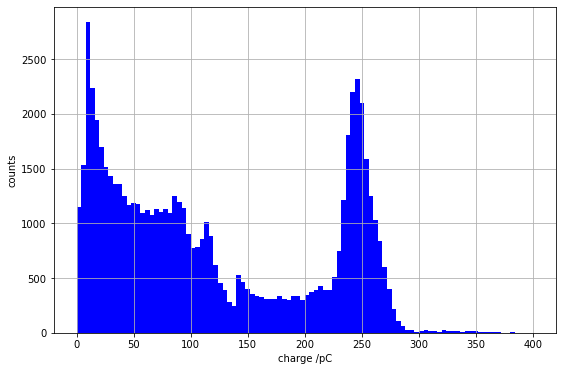

In [79]:
fig = plt.figure(figsize=(9,6), facecolor='white')
freq, bin_edges = np.histogram(-1*np.array(charges), 100, range=(0,400))
width = bin_edges[-1] - bin_edges[-2]
bin_centres = bin_edges[:-1] + width/2
plt.bar(bin_centres, freq, width=width, color="blue")
plt.xlabel('charge /pC')
plt.ylabel('counts')
plt.grid()
plt.savefig("/Users/williamquinn/Desktop/1400V_bi207_charge_spec.pdf")

In [86]:
file = ROOT.TFile("/Users/williamquinn/Desktop/pmt_short_templates.root", "READ")
file.ls()

TFile**		/Users/williamquinn/Desktop/pmt_short_templates.root	
 TFile*		/Users/williamquinn/Desktop/pmt_short_templates.root	
  KEY: TH1D	Template_Ch0;1	Template_Ch0
  KEY: TH1D	Template_Ch1;1	Template_Ch1


1 -217.99499999999978
2 -589.9949999999998
3 -1531.9949999999994
4 -4323.994999999999
5 -10492.994999999999
6 -20545.994999999977
7 -30571.995
8 -35233.99500000005
9 -32111.995000000035
10 -23645.994999999988
11 -14178.994999999995
12 -7388.995000000001
13 -4541.995000000001
14 -4761.994999999999
15 -5972.995000000003
16 -6514.994999999999
17 -5681.995000000001
18 -4103.994999999999
19 -2570.994999999999
20 -1473.9949999999994


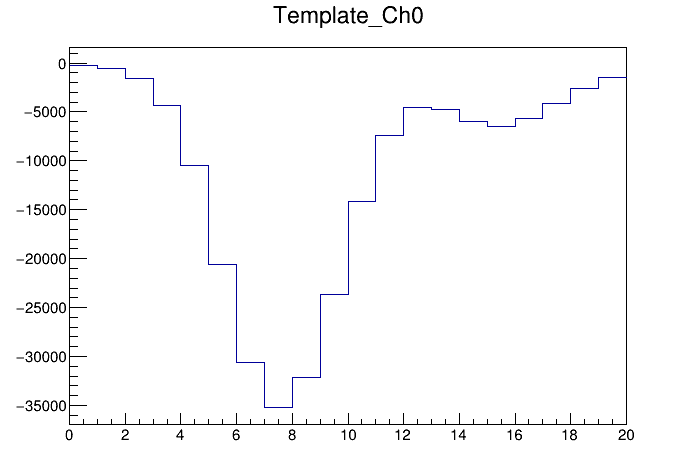

In [96]:
ROOT.gStyle.SetOptStat(0)
short_template = file.Get("Template_Ch0")
short_temp = []
for i in range(1, short_template.GetNbinsX() + 1):
    print(i, short_template.GetBinContent(i))
    short_temp.append(short_template.GetBinContent(i))
can = ROOT.TCanvas()
can.cd()
short_template.Draw()
can.Draw()
short_temp = np.array(short_temp)

20
-0.51095673137043


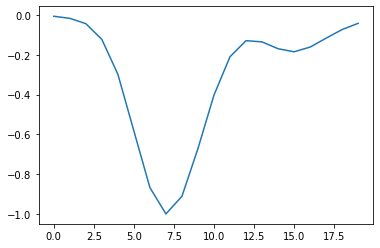

In [102]:
print(len(short_temp))
norm_short_temp = short_temp/np.sqrt(np.dot(short_temp, short_temp))
amp = np.min(norm_short_temp)
print(amp)
plt.plot(norm_short_temp /amp * -1)